In [1]:
import os
import pickle
import pandas as pd 
import numpy as np 
from selenobot.utils import RESULTS_DIR, DATA_DIR, dataframe_to_fasta
import fabapi
import matplotlib.pyplot as plt
import requests

%load_ext autoreload
%autoreload 2

# Validation

Another attempt at validating the selenoprotein results. In order to avoid extending predicted selenoprotein sequences, which requires downloading the genomes for each organism, we take a different approach. We hypothesize that, if predictions of truncated selenoptoeins are correct, the flagged sequences should align to the beginning of full-length sequences in the same KO group. To test this, we do the following:

1. Find KO groups which are (1) scientifically interesting (2) are predicted to contain both selenoproteins and non-selenoproteins (3) have a few hundred sequences, as opposed to thousands, which could increase the likelihood of MSA error.
2. Align the predicted truncated sequences to everything in the KO group.
3. Analyze the alignment location of the truncated sequences to the non-truncated sequences.

*Josh said the non-oxioreductase groups might be more interesting scientifically, as it could be that we are uncovering new uses of selenocysteine residues. I will start with those KO groups, and add on if needed.*

In [2]:
# First, collect some candidate KO groups from Figure 4. 
kos = [
    'K18299', # mexF, a translocase/efflux pump.
    'K19585', # oqxD, a translocase/efflux pump.
    'K05588', # hoxU, a translocase/efflux pump.
    'K10795', # prdD, does not have kosa functional annotation.
    'K25008', # rnfC2, does not have a functional annotation.
    'K03738', # aor
    'K15022', # fdhB
    'K20447'
    ]

In [15]:
# Load in the pickled results from the model run on GTDB. This data contains all predicted selenoproteins in GTDB, as well as some metadata.
# with open(os.path.join(RESULTS_DIR, 'selenoprotein_results.30Sep2023.pkl'), 'rb') as f:
#     results = pickle.load(f)
usecols = ['gene', 'KO', 'genome']
predictions = pd.read_csv(os.path.join(RESULTS_DIR, 'predicted_selenoproteins_StopCodon_KO.03Feb2024.csv'), usecols=usecols, low_memory=False)
predictions = predictions.rename(columns={'gene':'gene_id', 'genome':'genome_id', 'KO':'ko'}) # Clean up some of the column names.
predictions.head()

print(len(predictions))

174719


In [4]:
# print(set(predictions.ko))
for ko in ['K20447']:
    if ko in set(predictions.ko):
        print(f'KO {ko} is present in the predictions.')

KO K20447 is present in the predictions.


In [98]:
# How many sequences are in each KO group? Use Find-A-Bug
ko_counts = dict()
for ko in ['K20447']:
    response = requests.get(f'http://microbes.gps.caltech.edu:8000/count/annotations?&ko={ko}')
    print(f'Number of entries in {ko}:', response.text) # Why is this so slow? 
    ko_counts[ko] = int(response.text)

Number of entries in K20447: 344


In [101]:
# Download all GTDB sequences for each KO group using Find-A-Bug. # Limit of returned sequences is 500.
# for ko in kos:
for ko in ['K20447']:
    n_pages = ko_counts[ko] // 500 + 1
    df = [fabapi.get_annotations_with_ko(ko, get_sequences=True, page=page) for page in range(n_pages)]
    df = pd.concat(df).set_index('gene_id')
    df.to_csv(os.path.join(DATA_DIR, f'{ko}.csv'))

In [102]:
# For each gene in each KO group, determine whether or not the sequence is a predicted selenoprotein.
for ko in ['K20447']:
     # Load the data for the specified KO group.
     df = pd.read_csv(os.path.join(DATA_DIR, f'{ko}.csv'))
     # remove_cols = [col for col in df.columns if 'Unnamed:' in col]
     # df = df.drop(columns=remove_cols)
     # The gene IDs in the predictions have periods replaced with underscores, so need to do the same thing here.
     df.gene_id = df.gene_id.str.replace('.', '_')
     # Add a 'predictions' column indicating whether or not the gene ID is a predicted selenoprotein.
     df['prediction'] = df.gene_id.apply(lambda g : int(g in predictions.gene_id.values))
     # Write the data with the appended predictions back to the file. 
     df.set_index('gene_id').to_csv(os.path.join(DATA_DIR, f'{ko}.csv'))


It seems worth inspecting the lengths of the predicted selenoproteins versus predicted full-length in each Kegg Orthology group. 

Number of truncated sequences: 1550
Number of full-length sequences: 21758


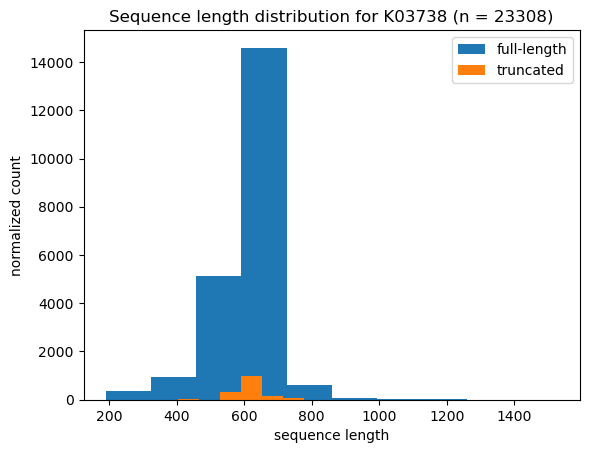

In [13]:
ko = 'K03738'
df = pd.read_csv(os.path.join(DATA_DIR, f'{ko}.csv'))
# Plot the length distribution of truncated versus non-truncated selenoproteins. 
sel_lengths = df[df.prediction == 1].seq.apply(len)
non_sel_lengths = df[df.prediction == 0].seq.apply(len)

print('Number of truncated sequences:', len(sel_lengths))
print('Number of full-length sequences:', len(non_sel_lengths))

n_bins = 50

fig, ax = plt.subplots()
ax.hist(non_sel_lengths) # , weights=np.ones(len(non_sel_lengths)) / len(non_sel_lengths))
ax.hist(sel_lengths) # , weights=np.ones(len(sel_lengths)) / len(sel_lengths))
ax.legend(['full-length', 'truncated'])

ax.set_title(f'Sequence length distribution for {ko} (n = {len(df)})')
ax.set_ylabel('normalized count')
ax.set_xlabel('sequence length')

plt.show()

The MUSCLE tool was used to generate multi-sequence alignments for each KO group. The documentation for the command-line tool can be found [here](https://drive5.com/muscle5/manual/cmd_align.html)

In [7]:
# First, we need to convert each CSV file into a FASTA file for the multo-sequence alignment. 
# TODO: It mightbe worth adding utilities to Find-A-Bug to output FASTA files.
for ko in kos:
     # Load the data for the specified KO group.
    df = pd.read_csv(os.path.join(DATA_DIR, f'{ko}.csv'), index_col=0)
    # Append an 'X' character to the end of each predicted selenoprotein, to make them visible in the alignment.
    df.loc[df.prediction == 1, 'seq'] = df[df.prediction == 1].seq.apply(lambda s : s[:-1] + 'X*')
    # Write the DataFrame to a FASTA file. 
    dataframe_to_fasta(df, os.path.join(DATA_DIR, f'{ko}.fa'))

In [9]:
# Run multi-sequence alignment on each KO group... 
ko = kos[-1]
output_path = os.path.join(DATA_DIR, f'{ko}.afa')
input_path = os.path.join(DATA_DIR, f'{ko}.fa')

In [10]:
! /home/prichter/muscle5.1.linux_intel64 --align '{input_path}' --output '{output_path}'


muscle 5.1.linux64 [12f0e2]  32.5Gb RAM, 16 cores
Built Jan 13 2022 23:17:13
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 344 seqs, avg length 542, max 962

00:00 10Mb   CPU has 16 cores, running 16 threads
13:55 1.2Gb   100.0% Calc posteriors 1.2Gb    15.7% Calc posteriors2:34 1.2Gb    21.2% Calc posteriors4:38 1.2Gb    34.7% Calc posteriorsalc posteriors6:11 1.2Gb    44.3% Calc posteriorsiors 47.7% Calc posteriors1.2Gb    68.7% Calc posteriorsiors9:47 1.2Gb    71.6% Calc posteriors
16:36 2.2Gb   100.0% Consistency (1/2)    36.2% Consistency (1/2)
19:19 2.2Gb   100.0% Consistency (2/2) 7:38 2.2Gb    44.5% Consistency (2/2)
19:19 2.2Gb   100.0% UPGMA5           
19:45 2.2Gb   100.0% Refining


Not really having any luck looking at the MSAs. I wonder if we are going about this the wrong way. Perhaps all, or many, of the results with Kegg annotations are false positives. Because they were successfully annotated, it's likely that they weren't truncated much (or at all). Also, only 10 percent of predicted selenoproteins have annotations! Perhaps it would be more interesting to extend and re-annotate the sequences, and then see if more of them get assigned Kegg ortho groups.

I would also be curious to look in to where selenocysteine tends to appear in the protein sequence (among the known annotations). If it tends to be towards the middle of the sequence, this would support the idea that the successfully-annotated predicted selenoproteins are false positives. In the Kegg ortho groups which do show up, do the selenocysteine residues tend to be towards the terminal end?

It might also be worth plotting the length difference between selenoproteins and non-selenoproteins in some of these Kegg ortho groups, or even computing something like KL divergence between length distributions, and plotting that. Might be worth doing the same thing for the training and test data. 

I also wonder if there is a better way to look at the MSA results than what I am currently doing. Perhaps there is useful information there, I am just having a hard time understanding what's going on. I am confused as to why the length of the alignment string things are greater than the longest sequence being aligned. How does that make sense?